The graphics in this RISE slideshow may not fit to certain screens or resolutions.  

### Overview

In this kernel, we compare assorted regression methods by their ability to predict residential real estate sale prices in King County, WA. 

We will begin by cleaning and transformation the data as it is prepared for the models.  Then we will use the evaluation metrics to tune each model and compare their performance.  These regression models are especially important to explore because they can offer insight into which features are most influential on sale price.  By the end of the analysis, we should be able to use the attributes of the tuned model to identify which specific characteristics of the estates most contributed to their saleprice.  

We start with an Ordinary Least Squares regression, and compare it to Ridge (L2) Regression, Lasso (L1) Regression, and ElasticNet Regression.

We will also examine a random forest model, and see which features each model prioritized by inspecting their attributes. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
import statsmodels.api as sm
from sklearn import neighbors
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import bartlett
from scipy.stats import levene
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_raw = pd.read_csv('Dataset zips/housesalesprediction/kc_house_data.csv')

In [3]:
df = df_raw.copy()

### Data Exploration

As shown below, all fields have a value for each record, thare are no nulls.  

The datatypes look accurate for each field except for date, which will be converted to datetime.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
df['date'] = pd.to_datetime(df['date'])

Since there are not too many features, we can use histograms to examine the distributions of each feature.  This will allow us to visually identify outliers and skewed distributions.  We can then identify where we need to transform the data. 

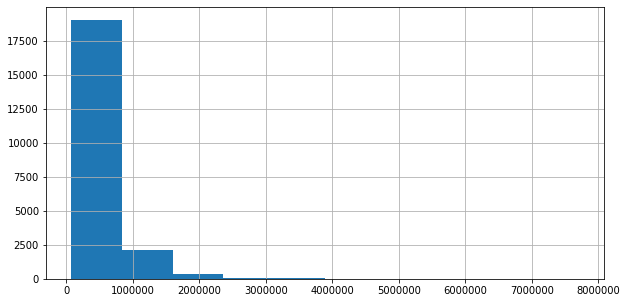

In [6]:
df['price'].hist(figsize = (10, 5))

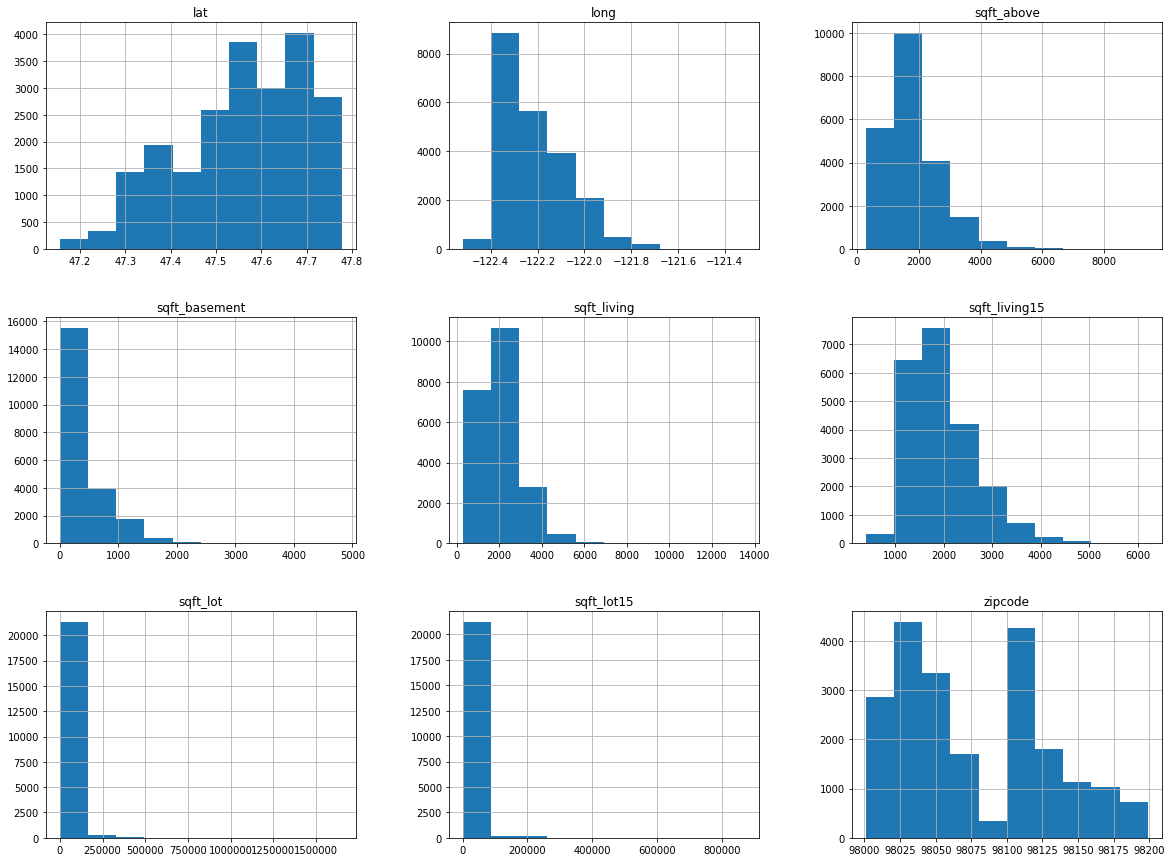

In [7]:
df[['sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_basement', 'sqft_above', 'zipcode', 'lat', 'long']].hist(figsize = (20, 15))
plt.show()

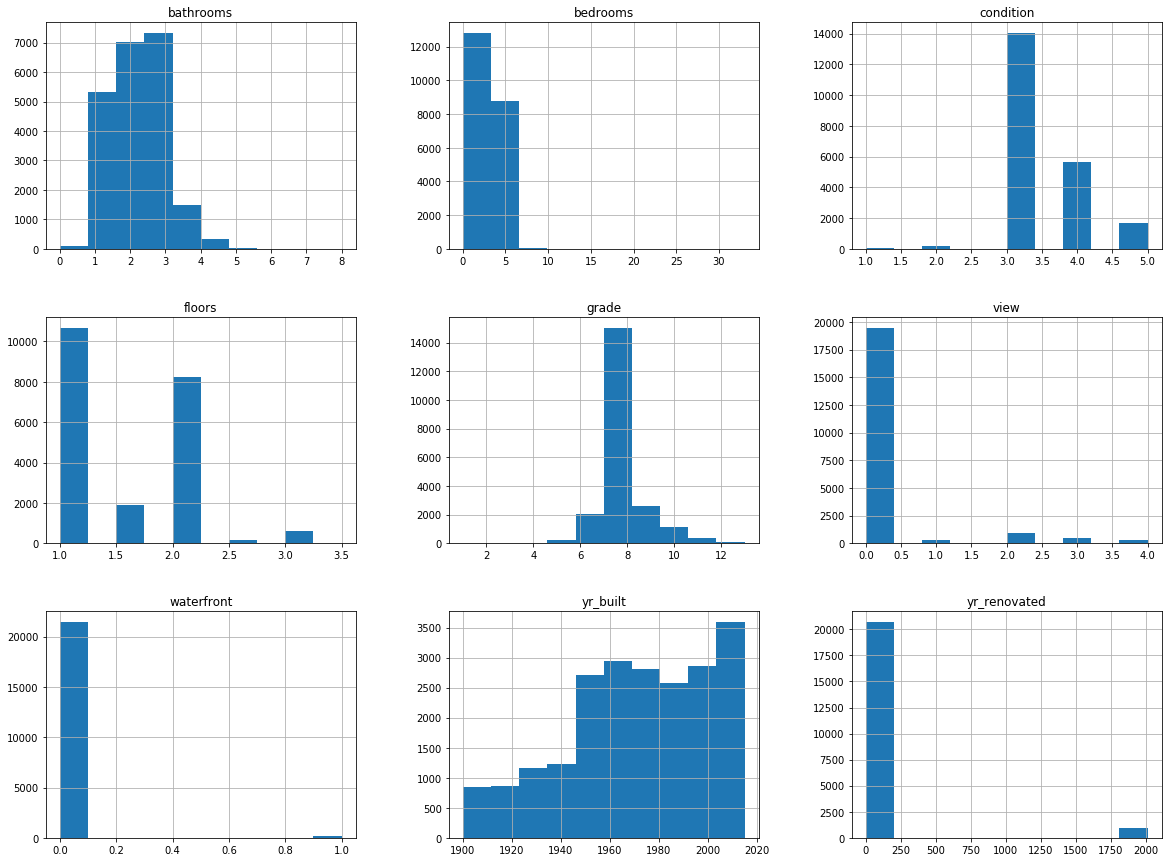

In [8]:
df[['bathrooms', 'bedrooms', 'floors', 'condition', 'grade', 'view', 'waterfront', 'yr_built', 'yr_renovated']].hist(figsize = (20, 15))
plt.show()

#### Saleprice

Lets start by examining the target variable, saleprice. We will begin by creating a histogram with more bins.

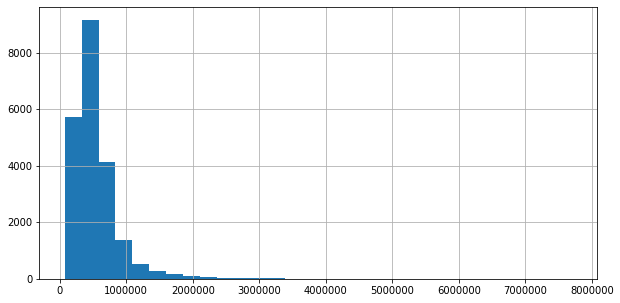

In [9]:
df['price'].hist(figsize = (10, 5), bins = 30)

The histogram does not show the oulying values for large sale price.  We can inspect a box and whisker plot instead.

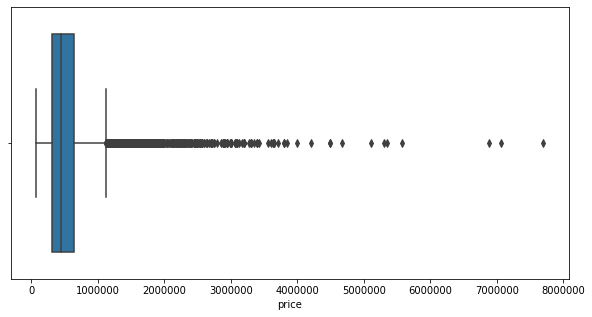

In [10]:
plt.figure(figsize = (10, 5))
sns.boxplot(df['price'])

There are some obvious outlying datapoints above 6 million, lets inspect them  more closely.

In [11]:
df['price'].sort_values(ascending = False).head(10)

7252    7700000.0
3914    7062500.0
9254    6885000.0
4411    5570000.0
1448    5350000.0
1315    5300000.0
1164    5110800.0
8092    4668000.0
2626    4500000.0
8638    4489000.0
Name: price, dtype: float64

Overall, this distribution has strong kurtosis, a rightward skew. 

There are 3 records that are obvious outliers above 6 million for saleprice. These 3 records will be removed because they interfere with the boxcox transformation used below, and would be removed in any case with the outlier detection methods used later.

In [12]:
df = df[df['price'] < 6000000]

Now we will investigate some transformations to achieve a distribution that is close to the normal gaussian.

Specifically, we will compare the log transformation to the boxcox transformation.

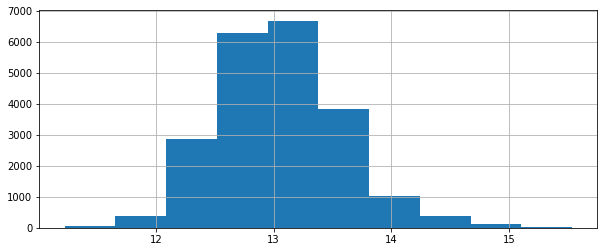

In [13]:
df['price_log'] = np.log(df['price'])
df['price_log'].hist(figsize = (10, 4))

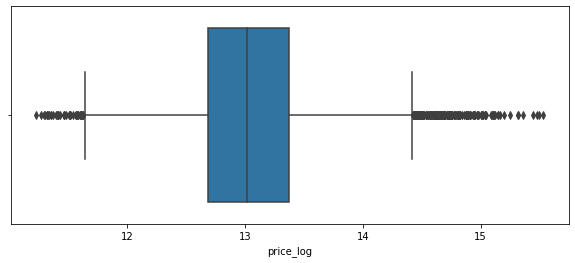

In [14]:
plt.figure(figsize = (10, 4))
sns.boxplot(df['price_log'])

Let's use a QQ plot to compare the original and transformed price distribution against a normal guassian distribution.

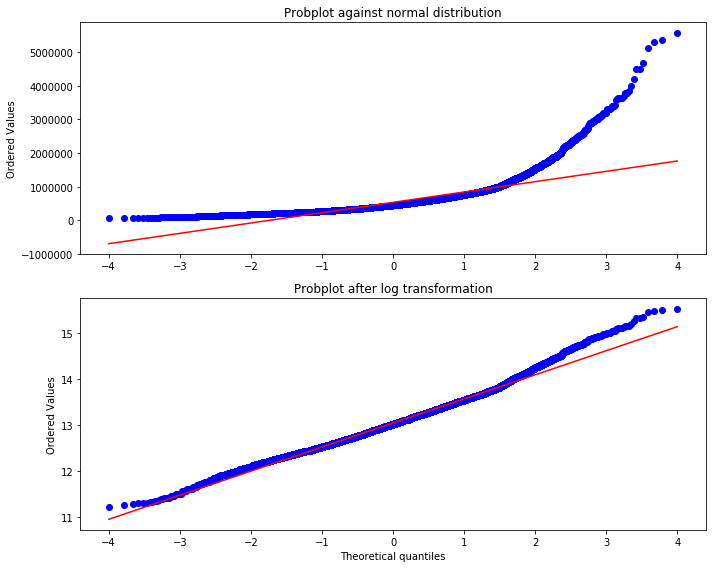

In [15]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
prob = stats.probplot(df['price'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')                       
ax2 = fig.add_subplot(212)
prob = stats.probplot(df['price_log'], dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after log transformation')
plt.tight_layout()

The log transformation results in a distribution that is much closer to the normal distribution as evidenced by the near linear correlation.

The most egregious outliers are on the high end of price after the log transformation.  The high prices are higher than expected for a normal distribution.

Now let's see if the boxcox transformation results in a more normal distribution.

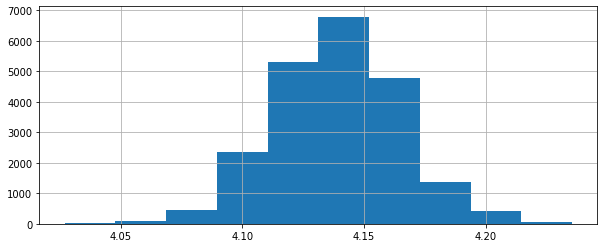

In [16]:
df['price_bxcx'] = stats.boxcox(df['price'])[0] # boxcox encounters an overflow error when prices above 6 mil are included.
df['price_bxcx'].hist(figsize = (10, 4))

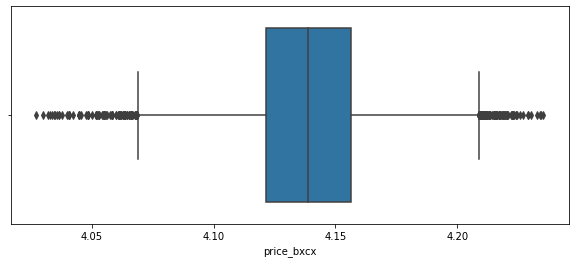

In [17]:
plt.figure(figsize = (10, 4))
sns.boxplot(df['price_bxcx'])

The mean does appear to be a bit more centered.  The whiskers are slightly more symmetrical, does the qq plot confirm this?

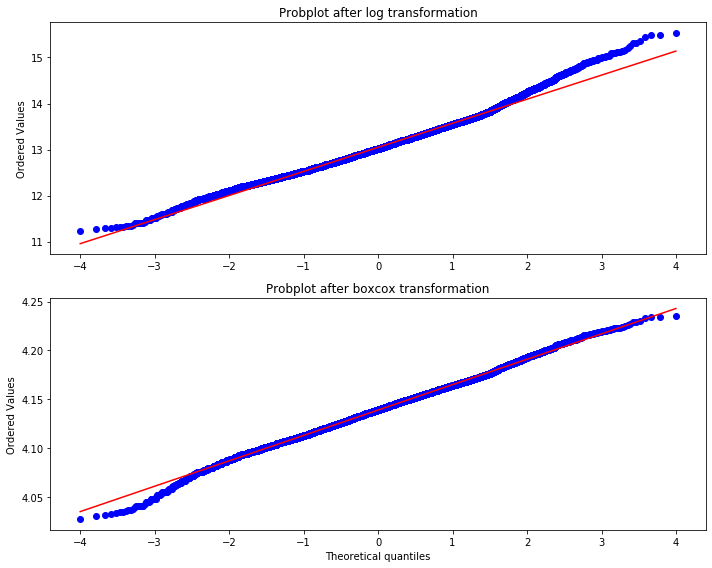

In [18]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
prob = stats.probplot(df['price_log'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot after log transformation')                         
ax2 = fig.add_subplot(212)
prob = stats.probplot(df['price_bxcx'], dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after boxcox transformation')
plt.tight_layout()


Yes, the boxcox transformation does seem to create the most normal distribution.  Only the low values of sale price deviate from the guassian.

Perhaps we should identify and remove more outliers in the prices.  We want to avoid removing too much data, however, since sale price is the target feature.  We want the model to be able to predict both high and low prices, not just the most common prices. 

When examining the price, we will avoid removing more than 213 records, 1% of the data.  

Let's first use interquartile range to identify outliers.

In [19]:
# NumPy's percentile() method returns the 
# values of the given percentiles. In our case,
# we give 75 and 25 as parameters which corresponds 
# to the third and the first quartile.
q75, q25 = np.percentile(df['price_bxcx'], [75 ,25])
iqr = q75 - q25

for threshold in np.arange(1,5.5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The IQR threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((df['price_bxcx'] > max_val) 
                      | (df['price_bxcx'] < min_val))[0]))
    ))

The IQR threshold is: 1.0
Number of outliers is: 993
The IQR threshold is: 1.5
Number of outliers is: 232
The IQR threshold is: 2.0
Number of outliers is: 40
The IQR threshold is: 2.5
Number of outliers is: 4
The IQR threshold is: 3.0
Number of outliers is: 0
The IQR threshold is: 3.5
Number of outliers is: 0
The IQR threshold is: 4.0
Number of outliers is: 0
The IQR threshold is: 4.5
Number of outliers is: 0
The IQR threshold is: 5.0
Number of outliers is: 0


A typical choice for the interquartile range threshold would be 1.5 IQRs beyond the first or third quartile.  This threshold would identify 232 outliers, and thus removes too much of the data (greater than 1%).  By increasing the threshold to 2 IQRs beyond the initial quartile, only 40 records are outliers.  Increasing the IQR threshold further does not identify many or any outliers.  

Since our distribution is close to normal we don't need to use IQR to identify outliers, lets see if a method based on the mean instead of the median will be more effective.  

Now detecting outliers based on the distribution's mean and standard deviation using z-scores.

In [20]:
from scipy.stats import zscore

#The z-scores identify the number of standard deviation a record is from the mean.

z_scores = zscore(df['price_bxcx'])
for threshold in range(1,6):
    print("The z-score threshold is: {}".format(threshold))
    #print("The indices of the outliers:")  # uncomment to add the idices of each outlying record.
    #print(np.where(z_scores > threshold))
    print("Number of outliers is: {}".format(len((np.where(abs(z_scores) > threshold)[0]))))

The z-score threshold is: 1
Number of outliers is: 6734
The z-score threshold is: 2
Number of outliers is: 1015
The z-score threshold is: 3
Number of outliers is: 106
The z-score threshold is: 4
Number of outliers is: 7
The z-score threshold is: 5
Number of outliers is: 0


A typical choice for the z-score's threshold would be 3 sigma.  This threshold results in 106 outliers, which is still less than 1% of the data.  

Thus, for this analysis, a threshold of 3 sigma will be chosen.

Since the distribution is close to normal after the boxcox transformation, we will detect outliers use the z-score, and thus the datapoints relation to the mean.

We need to keep the z_scores in the dataframe, since they will change if we recalculate on the reduced dataframe.

We can then remove records with outlying price values.  We will also create df_prime, the dataset with all datapoints.

In [21]:
df['price_bxcx_zscore'] = z_scores
df_prime = df.copy() # Creating a copy of the orginal dataframe in case we need to reference it later.
df = df[abs(df['price_bxcx_zscore']) <= 3]

Now the reduced dataframe has no outlying sale prices.  Lets see how the cleaned and transformed target feature compares to its original distribution and to the normal using a prob plot.

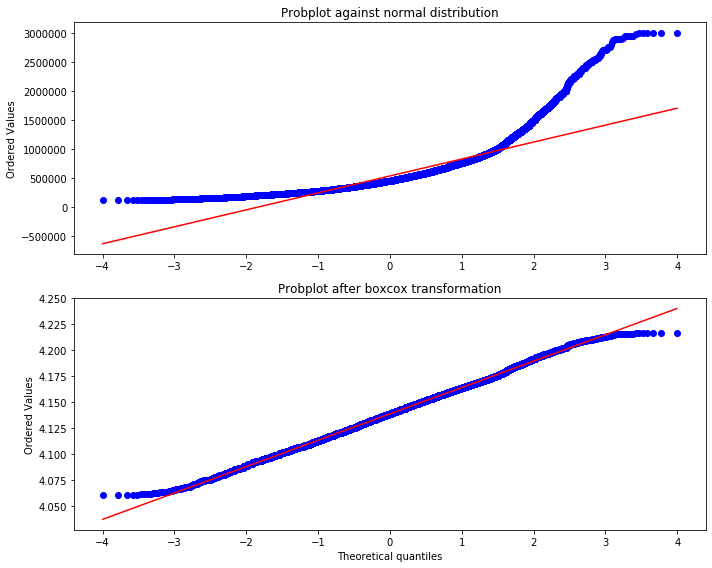

In [22]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
prob = stats.probplot(df['price'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')                  
ax2 = fig.add_subplot(212)
prob = stats.probplot(df['price_bxcx'], dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after boxcox transformation')
plt.tight_layout()

We can also use the Jarque-Bera test and normality test to see if this distribution is close to normal.

In [23]:
print('JarqueBeraResult' + str(stats.jarque_bera(df['price_bxcx'])))
print(stats.normaltest(df['price_bxcx']))

JarqueBeraResult(11.371993097744443, 0.003393150124257449)
NormaltestResult(statistic=11.590523891563787, pvalue=0.003041933500669542)


The statistical error in both cases is only 11.  On a scale that reaches into the millions, this is a small error from normal.  The p-value is below 0.05 so this is a statistically significant error even though it is small.

### Feature Selection

Let's examine some of the features to see if they have any correlation with the target, saleprice.  

Do the saleprices chage over time? Lets examine the date of sale.  

##### Date

The data is spread out over a 1 year time frame from May 2014 to 2015.  Do any parts of the year have significantly fewer house sales? does the price change with respect to time for this short of a timeframe?

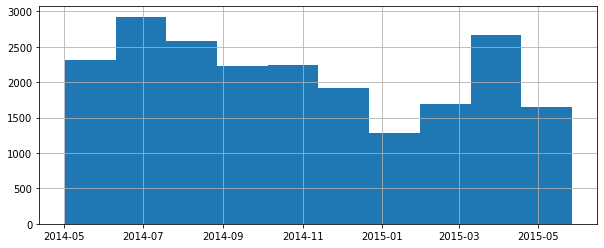

In [24]:
df['date'].hist(figsize = (10, 4))

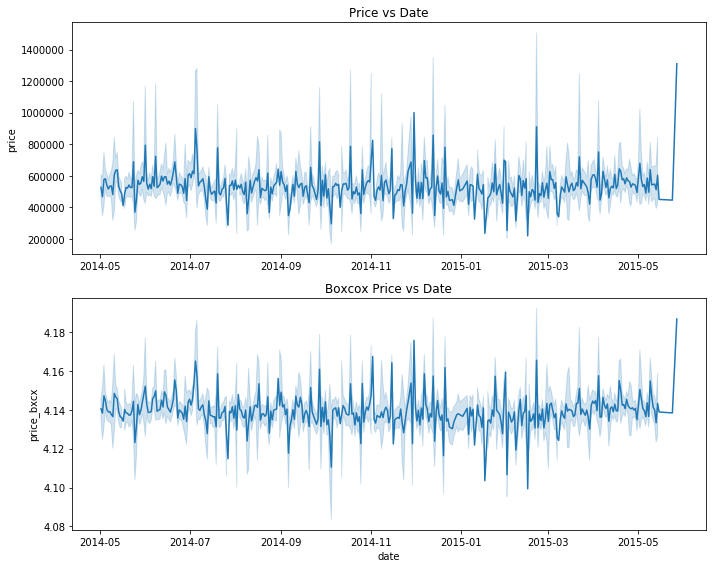

In [25]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
line = sns.lineplot(x = df['date'], y = df['price'])
ax1.set_xlabel('')
ax1.set_title('Price vs Date')
ax2 = fig.add_subplot(212)
line = sns.lineplot(x = df['date'], y = df['price_bxcx'])
ax2.set_title('Boxcox Price vs Date')
plt.tight_layout()

The date of the sale does not appear to have any correlation with the saleprice.  This is to be expected since all data is collected within a 1 year timeframe.

##### Zipcode

How about the zipcode, are saleprices significantly different in different zip codes? 

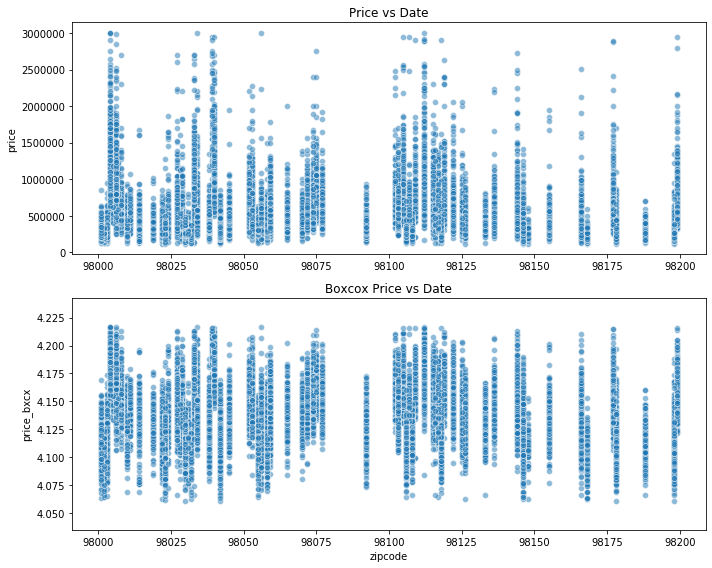

In [26]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
scatter = sns.scatterplot(x = df['zipcode'], y = df['price'], alpha = 0.5)
ax1.set_xlabel('')
ax1.set_title('Price vs Date')
ax2 = fig.add_subplot(212)
scatter = sns.scatterplot(x = df['zipcode'], y = df['price_bxcx'], alpha = 0.5)
ax2.set_title('Boxcox Price vs Date')
plt.tight_layout()

Most dates and zipcodes seem to contain a wide range of prices, thus we will not account for the date or location of the house.  These features can ba useful in predicting house prices, but are out of the scope of this analysis.  

We will create a list of the features, 'feat', that drops all fields which will not be used as features for predicting price.

In [27]:
feat = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15']

Now let's examine the field in the current feature list.

##### Waterfront

Waterfront is a boolean categorical feature that returns 1 if the lot borders an ocean, lake, or river.

How many lots actually border a water feature?  Is the price generally higher for those lots?

In [28]:
df['waterfront'][df['waterfront'] != 0].count()

143

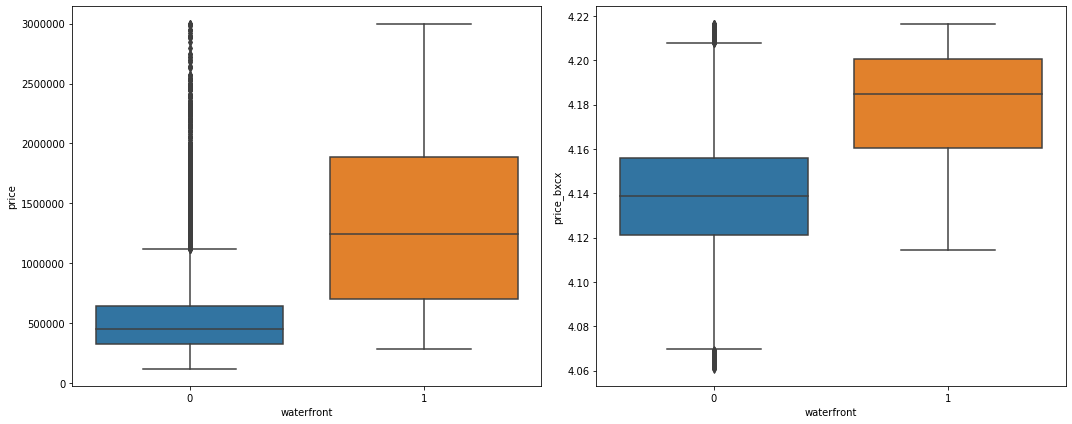

In [29]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['waterfront'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['waterfront'], y = df['price_bxcx'])
plt.tight_layout()

###### View

The view from each property is graded on a scale of 0 to 4.  

In [30]:
np.unique(df['view'], return_counts = True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([19414,   330,   959,   508,   293], dtype=int64))

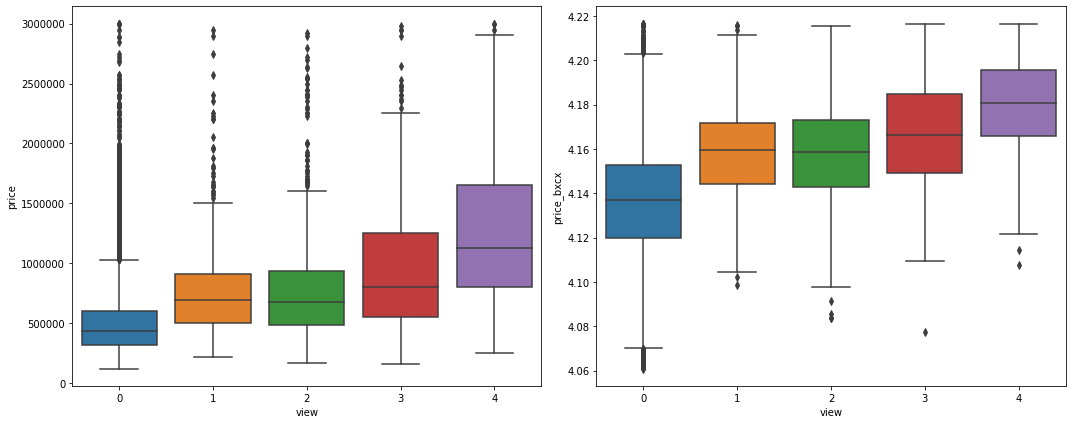

In [31]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['view'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['view'], y = df['price_bxcx'])
plt.tight_layout()

##### Condition

The condition measures how well kept the property is, where low values indicate a need for repairs and high values indicate regular maintenance.

In [32]:
np.unique(df['condition'], return_counts = True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([   27,   162, 13962,  5657,  1696], dtype=int64))

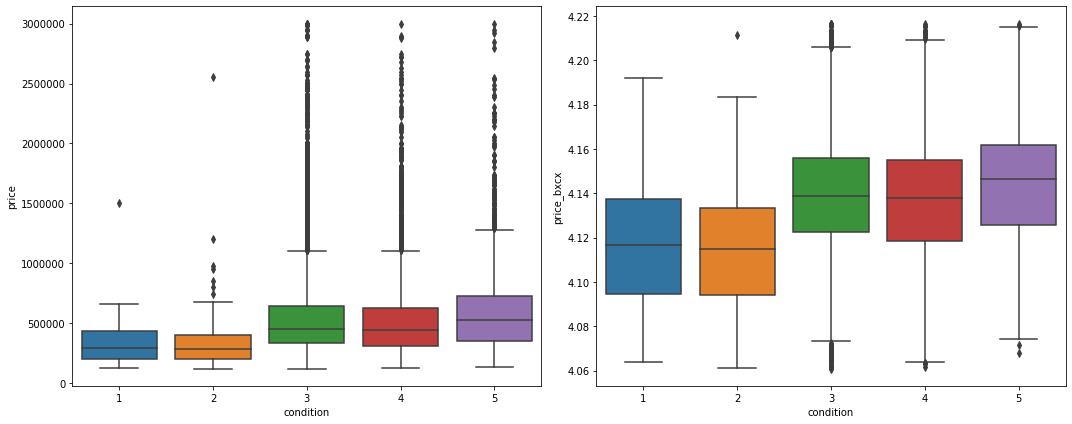

In [33]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['condition'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['condition'], y = df['price_bxcx'])
plt.tight_layout()

The condition only seems to influence price when it changes from 2 to 3, thus we can bucketize the low and high condition records into a boolean categorical field.  The curoff will be set at 2.5.

In [34]:
df['condition'] = pd.cut(df['condition'], [0, 2.5, 5.5], labels = ['low', 'high']) # cut condition into 2 buckets
df['condition'] = pd.get_dummies(df['condition'], drop_first=True) # make condition into a boolean dummy variable, 1 is high quality

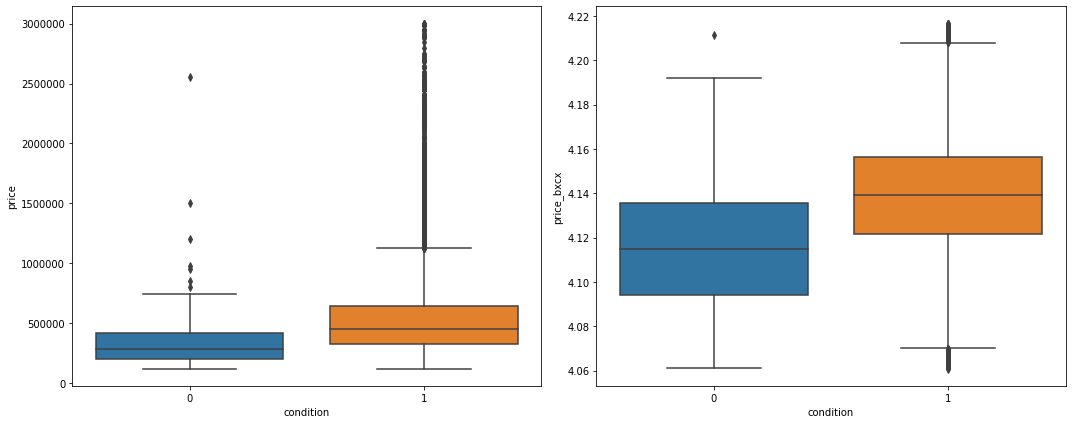

In [35]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['condition'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['condition'], y = df['price_bxcx'])
plt.tight_layout()

##### Grade

This feature represents the quality of construction and improvements, where values below 6 represent buildings that do not even meet code.  High values generally indicate custom design and architecture.

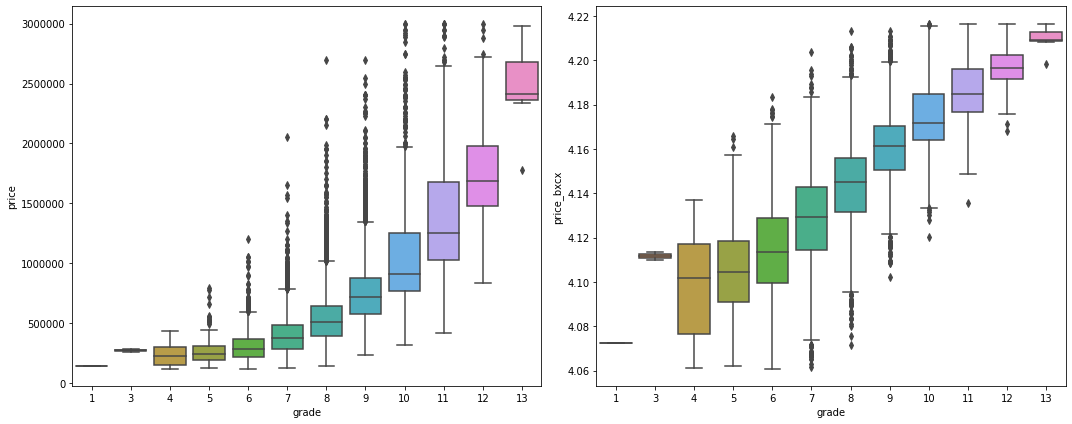

In [36]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['grade'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['grade'], y = df['price_bxcx'])
plt.tight_layout()

##### Floors

The number of stories in the house.  Decimal values of 0.5 refer to smaller spaces such as attics or lofts that do not represent an entire new floor.  

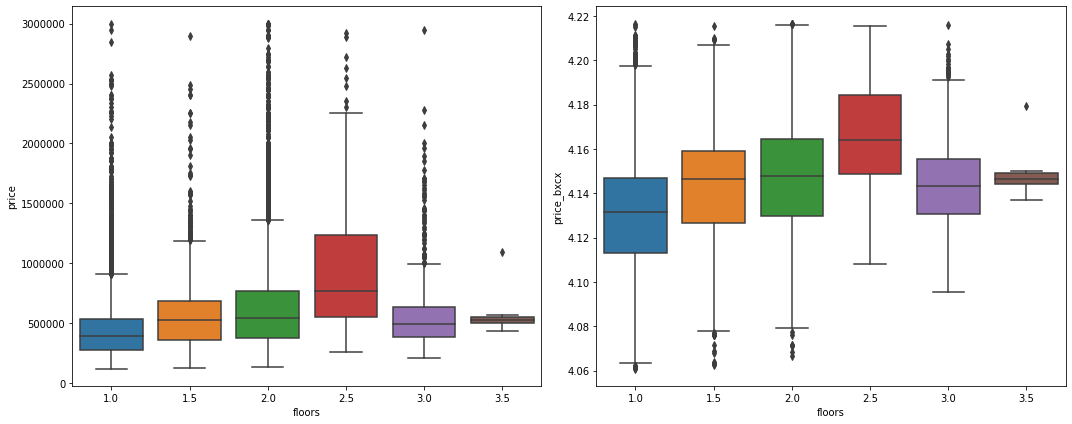

In [37]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['floors'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['floors'], y = df['price_bxcx'])
plt.tight_layout()

##### Bathrooms

Simply the number of bathrooms in the residence.  Decimal values such as 2.5 represent half bathrooms (those without a bath/shower).  

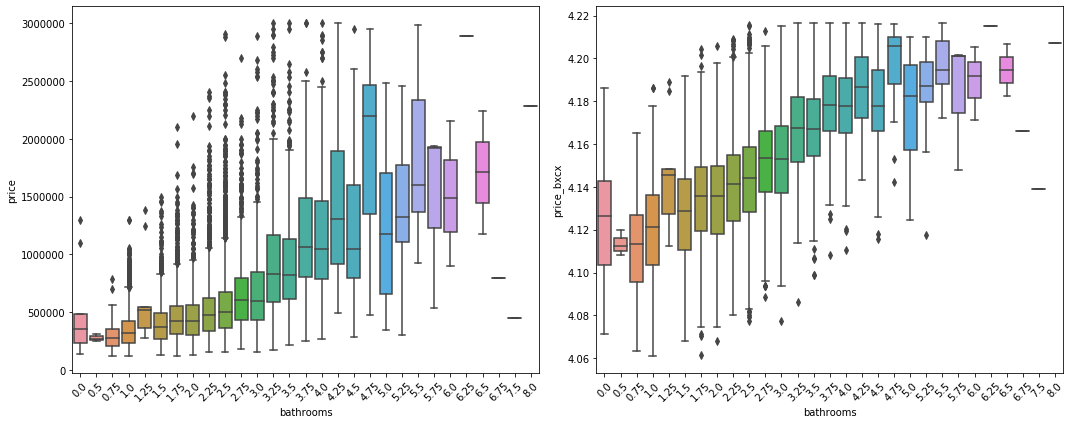

In [38]:
plt.figure(figsize = (15, 6))
plt.subplot(121).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price'])
plt.subplot(122).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price_bxcx'])
plt.tight_layout()

Some records have no bathrooms.  Now, this is theoretically a possibility if the residence used a communal space I suppose.  However, seeing as this dataset is focused on houses, this possiblity seems unlikely.  Additionally, the prices for properties with 0 bathrooms have a wide distribution and overall larger values than those with one half or full bathroom.  

In [39]:
df[feat][df['bathrooms'] == 0]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
875,0,0.0,3064,4764,3.5,0,2,1,7,3064,0,1990,0,2360,4000
3119,0,0.0,1470,979,3.0,0,2,1,8,1470,0,2006,0,1470,1399
5832,1,0.0,600,24501,1.0,0,0,0,3,600,0,1950,0,990,22549
6994,0,0.0,4810,28008,2.0,0,0,1,12,4810,0,1990,0,4740,35061
9773,0,0.0,2460,8049,2.0,0,0,1,8,2460,0,1990,0,2520,8050
9854,0,0.0,1470,4800,2.0,0,0,1,7,1470,0,1996,0,1060,7200
10481,1,0.0,690,23244,1.0,0,0,1,7,690,0,1948,0,1690,19290
14423,0,0.0,844,4269,1.0,0,0,1,7,844,0,1913,0,1380,9600
19452,0,0.0,290,20875,1.0,0,0,0,1,290,0,1963,0,1620,22850


Curiously, many of these no bathroom residences also have no bedrooms. It also seems unusual to have multiple floors but no bathrooms.

In this case, we will impute the median number of bathrooms based on the number of floors for that residence.  

In [40]:
df['bathrooms'].replace(0, None, inplace = True)
df[['floors']].join(df.groupby('floors', group_keys = False).transform(lambda x: x.fillna(x.median())).astype(float))
df['bathrooms'].min()

0.5

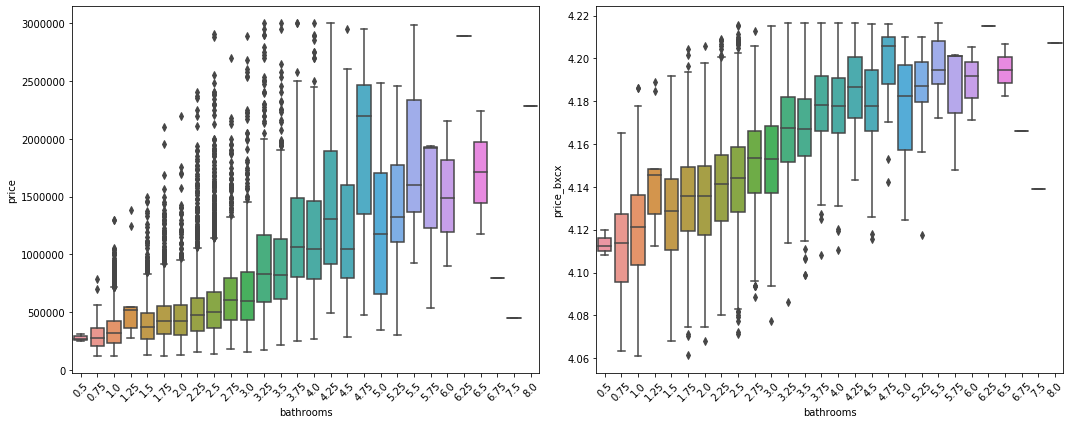

In [41]:
plt.figure(figsize = (15, 6))
plt.subplot(121).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price'])
plt.subplot(122).tick_params(axis = 'x', rotation = 45)
sns.boxplot(x = df['bathrooms'], y = df['price_bxcx'])
plt.tight_layout()

##### Bedrooms

The number of bedroom in the residence.  One record shown below has 33 bedrooms.  This seems outlandish and is assumed to be an error.  It will be replaced with the mean.

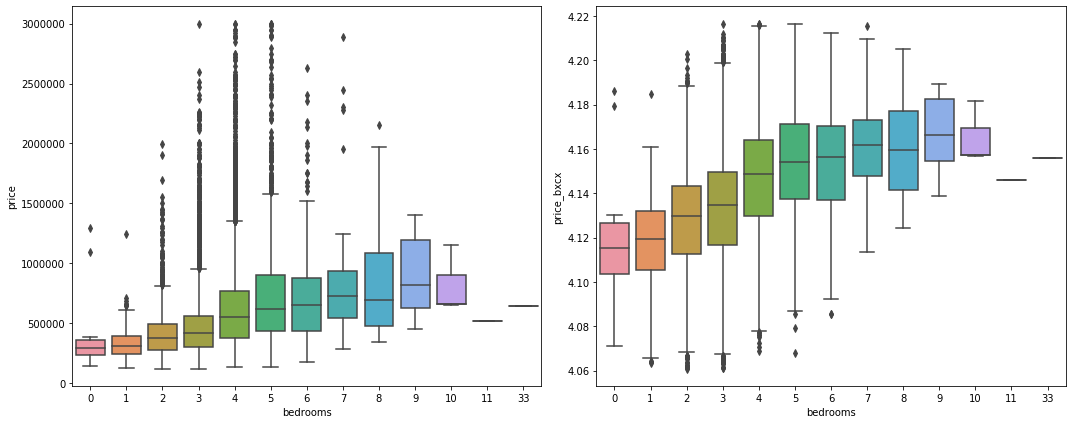

In [42]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['bedrooms'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['bedrooms'], y = df['price_bxcx'])
plt.tight_layout()

One record has 33 bedrooms.  This seems outlandish and is assumed to be an error.  

In [43]:
df[feat][df['bedrooms'] == 33]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
15870,33,1.75,1620,6000,1.0,0,0,1,7,1040,580,1947,0,1330,4700


In [44]:
df['price'][df['bedrooms'] == 33]

15870    640000.0
Name: price, dtype: float64

The lot that allegedly has 33 bedrooms only has 1.75 bathrooms, 1,620 square footage, and a price of 64,000.

It seems much more likely the value was entered incorrectly, it will be replaced with 3.

In [45]:
df['bedrooms'][df['bedrooms'] == 33] = 3

Much like the bathrooms, some records have no bedrooms.  These properties could be studio style and thus not count the main room as a true bedroom.  Notably, the properties with 0 bedrooms also have the lowest price.  Let's take a cursory glance ar these entries to see if they make any sense.

In [46]:
df[feat][df['bedrooms'] == 0]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
875,0,2.25,3064,4764,3.5,0,2,1,7,3064,0,1990,0,2360,4000
3119,0,1.00,1470,979,3.0,0,2,1,8,1470,0,2006,0,1470,1399
3467,0,1.50,1430,1650,3.0,0,0,1,7,1430,0,1999,0,1430,1650
4868,0,1.00,390,5900,1.0,0,0,0,4,390,0,1953,0,2170,6000
6994,0,2.50,4810,28008,2.0,0,0,1,12,4810,0,1990,0,4740,35061
8477,0,2.50,2290,8319,2.0,0,0,1,8,2290,0,1985,0,2500,8751
8484,0,2.50,1810,5669,2.0,0,0,1,7,1810,0,2003,0,1810,5685
9773,0,2.50,2460,8049,2.0,0,0,1,8,2460,0,1990,0,2520,8050
9854,0,2.00,1470,4800,2.0,0,0,1,7,1470,0,1996,0,1060,7200
12653,0,2.50,1490,7111,2.0,0,0,1,7,1490,0,1999,0,1500,4675


Many of these records have multiple floors, which seems unusual for a residence with no bedrooms.  Thus, we will use the same strategy of imputing the median  number of bedrooms for that number of floors.

In [47]:
df['bedrooms'].replace(0, None, inplace = True)
df[['floors']].join(df.groupby('floors', group_keys = False).transform(lambda x: x.fillna(x.median())).astype(float))
df['bedrooms'].min()

1

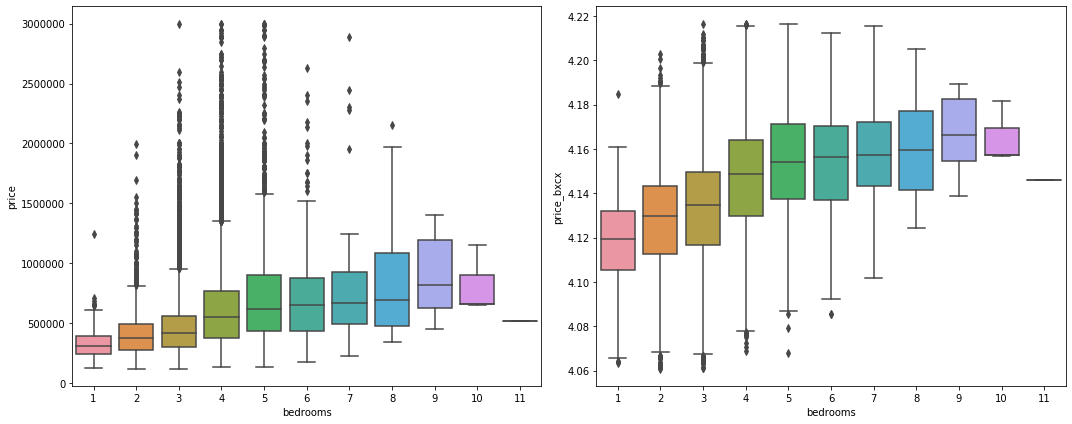

In [48]:
plt.figure(figsize = (15, 6))
plt.subplot(121)
sns.boxplot(x = df['bedrooms'], y = df['price'])
plt.subplot(122)
sns.boxplot(x = df['bedrooms'], y = df['price_bxcx'])
plt.tight_layout()

Now that these features have been cleaned and error corrected, we can move forward with examining their predictive power. 

##### Correlation

So far we have only examined the features with respect to our target, price.  With a correlation matrix, we can inspect their correlations with each other. 

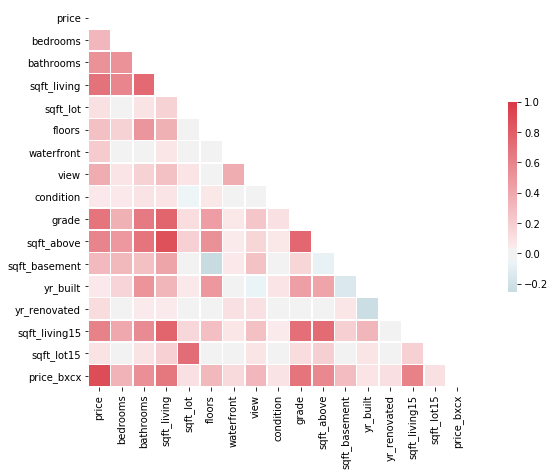

In [49]:
mask = np.zeros_like(df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'price_log', 'price_bxcx_zscore'], axis = 1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # Generate a mask for the upper triangle
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
plt.figure(figsize=(14, 7))
sns.heatmap(df.drop(['id', 'date', 'zipcode', 'lat', 'long', 'price_log', 'price_bxcx_zscore'], axis = 1).corr(), mask=mask, cmap= cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

The features most correlated with price are: sqft_living, sqft_above, grade, sqft_living15, lowest are yr_built, yr_renovated, condition, and sqft_lot15.

We will begin by closely examining the most correlated feature, sqft_living.

<Figure size 576x576 with 0 Axes>

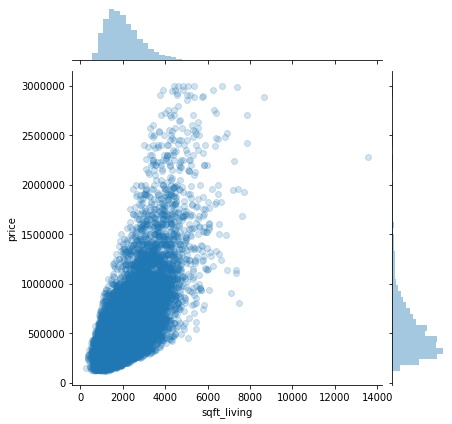

In [50]:
plt.figure(figsize = (8, 8))
sns.jointplot(df['sqft_living'], df['price'], alpha = 0.2)
plt.show()

It appears that a linear model would fit well.  We can use it as a baseline comparison for future models.  

### Modeling

Let's create some regression models to predict houseprice.

#### Simple Linear Regression

To start we use a single feature, living area square footage (sqft_living), to predict the target, price.  This will represent a simple one dimensional approach with minimal transformation of the data to be used as a baseline.

We will create train and test sets, then use Ordinary Least Squares on the train data to fit the model and comapre its predictions to the test set.

In [51]:
Y = np.array(df['price'])

X = np.array(df['sqft_living']).reshape(-1, 1)

# Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

# Adding constants to the feature train and test sets.
X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

# .fit method estimates the coefficients using OLS. 
lrm = linear_model.LinearRegression()
lrm.fit(X_train_cons, y_train)

# Get predictions.
y_preds = lrm.predict(X_test_cons)

The red line below represents the predicted prices for each square footage.  It appears to underpredict large saleprices.

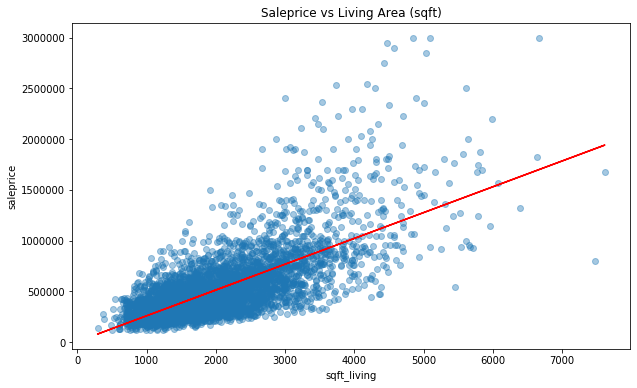

In [53]:
plt.figure(figsize = (10, 6))
plt.scatter(X_test, y_test, alpha = 0.4)
plt.plot(X_test, y_preds, color="red")
plt.xlabel('sqft_living')
plt.ylabel('saleprice')
plt.title('Saleprice vs Living Area (sqft)')
plt.show()

In this next plot, the red line is simply the identity (y = 1x).  Points below the line represent prices that are underpredicted by the model, and those above were overpredicted.  This gives further evidence that the model underpredicts very large prices. 

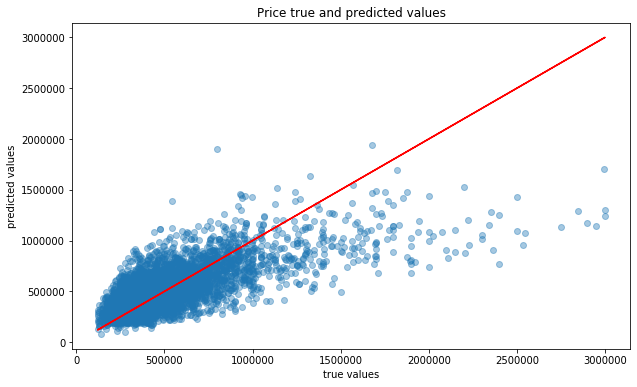

In [54]:
plt.figure(figsize = (10, 6))
plt.scatter(y_test, y_preds, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Price true and predicted values")
plt.show()

Let's examine how this model scores; we can use the errors of prediction for this model as a baseline to comapre future models. 

In [55]:
print("R-squared of the training set: {}".format(lrm.score(X_train_cons, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lrm.score(X_test_cons, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

R-squared of the training set: 0.47550968315424036
-----Test set statistics-----
R-squared of the test set: 0.47927689095081816
Mean absolute error of the prediction is: 166173.2674542523
Mean squared error of the prediction is: 57325765542.480835
Root mean squared error of the prediction is: 239427.99657199832
Mean absolute percentage error of the prediction is: 34.7204826486384


Both R-squared values for train and test set are close, so the model is likely not overfit.  However, R-squared is only around 0.5, and mean absolute percentage of error is 35%.  The earlier plots show that some of the true values are much larger than the predicted value.  Can we create a model that better predicts prices?

#### Multiple Regression

Now we will create some multi dimensional regression models.  We will again start with Ordinary Least Squares, but this time with all the features included.  We will then compare this to the various regularization techniques, Lasso (L1), Ridge(L2), and ElasticNet regression.  

In [56]:
Y = df['price_bxcx']

X = df[feat]

# Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

# Adding constants to the feature train and test sets.
X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

#### Ordinary Least Squares

In [57]:
# .fit method estimates the coefficients using OLS. 
lrm = linear_model.LinearRegression()
lrm.fit(X_train_cons, y_train)

# Get predictions.
y_preds = lrm.predict(X_test_cons)

In [58]:
results = sm.OLS(y_train, X_train_cons).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_bxcx   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1969.
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        01:33:33   Log-Likelihood:                 47083.
No. Observations:               17203   AIC:                        -9.414e+04
Df Residuals:                   17188   BIC:                        -9.402e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.5831      0.011    436.351      0.000       4.562       4.604
bedrooms         -0.0012      0.000     -7.135      0.000      -0.002      -0.001
bathrooms         0.0042      0.000     14.853      0.000       0.004       0.005
sqft_living    4.405e-06   2.04e-07     21.550      0.000       4e-06    4.81e-06
sqft_lot       1.319e-08   4.32e-09      3.052      0.002    4.72e-09    2.17e-08
floors            0.0062      0.000     20.188      0.000       0.006       0.007
waterfront        0.0153      0.002      9.679      0.000       0.012       0.018
view              0.0015      0.000      7.997      0.000       0.001       0.002
condition         0.0089      0.001      6.871      0.000       0.006       0.011
grade             0.0099      0.000     53.655      0.000       0.010       0.010
sqft_above    -4.113e-07   1.94e-07     -2.125      0.034   -7.91e-07    -3.2e-08
sqft_basement  4.816e-06    2.3e-07     20.950      0.000    4.37e-06    5.27e-06
yr_built         -0.0003    5.5e-06    -52.072      0.000      -0.000      -0.000
yr_renovated   1.439e-07   3.15e-07      0.457      0.648   -4.73e-07    7.61e-07
sqft_living15  5.969e-06   2.95e-07     20.251      0.000    5.39e-06    6.55e-06
sqft_lot15    -2.205e-08   6.48e-09     -3.404      0.001   -3.47e-08   -9.35e-09
==============================================================================
Omnibus:                      271.113   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              287.289
Skew:                          -0.297   Prob(JB):                     4.13e-63
Kurtosis:                       3.218   Cond. No.                     2.72e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.8e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Looking at the coefficient for each feature and its corresponding p-value, we can see that the only features that has a p-value above 0.05 are sqft_above and yr_renovated.  The high p-value suggests that there is a statistically significant chance these features have a coefficient equal to 0 and thus no affect on the target. 

The p-value for each feature tests the null hypothesis that the coefficient is equal to zero (no effect). A value below 0.05 indicates that you can reject the null hypothesis. Thus, a predictor with a low p-value is likely to be meaningful because changes in the predictor's value are related to changes in the response variable.

The feature sqft_above is also highly correlated with sqft_living as shown in the heatmap earlier.

With this in mind, sqft_above and yr_renovated are strong candidates for dropping from the feature list.  

It should also be noted that the coefficient represents the change in price for a 1 unit change in the features value.  Thus a boolean feature such as waterfront will naturally have a higher coefficient than a continuous one like sqft_living.  To represent this, we will multiply each feature's coefficient by its total range of values.  

In [59]:
coefficients = list(zip(feat, lrm.coef_))
OLS_coef = pd.DataFrame(data = coefficients, columns = ['feature', 'coefficient'])
OLS_coef['coef_by_range'] = range(0, OLS_coef.shape[0])
for feature in feat:
    OLS_coef['coef_by_range'][OLS_coef['feature'] == feature] = OLS_coef['coefficient'][OLS_coef['feature'] == feature] * (df[feature].max() - df[feature].min())
OLS_coef.sort_values(by = 'coef_by_range', ascending = False)

,feature,coefficient,coef_by_range
9,sqft_above,9.885590e-03,9.015658e+01
2,sqft_living,4.249092e-03,5.630047e+01
3,sqft_lot,4.404734e-06,7.271507e+00
14,sqft_lot15,5.968962e-06,5.196274e+00
8,grade,8.934374e-03,1.072125e-01
6,view,1.532456e-02,6.129825e-02
5,waterfront,6.207788e-03,6.207788e-03
7,condition,1.488330e-03,1.488330e-03
13,sqft_living15,1.438738e-07,8.360508e-04
11,yr_built,4.816075e-06,5.538487e-04


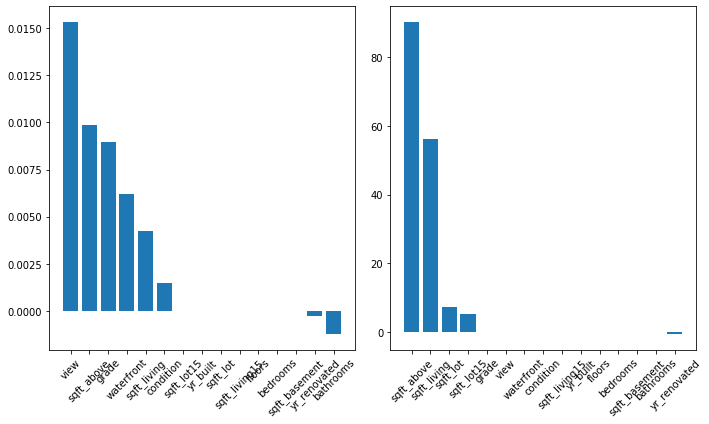

In [60]:
plt.figure(figsize = (10, 6))
plt.subplot(121).tick_params(axis = 'x', rotation = 45)
plt.bar(OLS_coef.sort_values(by = 'coefficient', ascending = False)['feature'], OLS_coef.sort_values(by = 'coefficient', ascending = False)['coefficient'])
plt.subplot(122).tick_params(axis = 'x', rotation = 45)
plt.bar(OLS_coef.sort_values(by = 'coef_by_range', ascending = False)['feature'], OLS_coef.sort_values(by = 'coef_by_range', ascending = False)['coef_by_range'])
plt.tight_layout()


Although features such as view, waterfront, and grade have high coefficients, they do not actually have strong predictive power compared to sqft_living.  Recall that sqft_above did have a low enough p-value to be statistically significant.

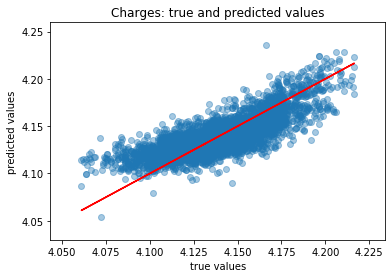

R-squared of the training set: 0.6159623672757693
-----Test set statistics-----
R-squared of the test set: 0.613561116335936
Mean absolute error of the prediction is: 0.012716352775384552
Mean squared error of the prediction is: 0.00025261933571643945
Root mean squared error of the prediction is: 0.015894003136920524
Mean absolute percentage error of the prediction is: 0.30741517807014435


In [61]:
# We are making predictions here
y_preds = results.predict(X_test_cons)

plt.scatter(y_test, y_preds, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lrm.score(X_train_cons, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lrm.score(X_test_cons, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

For this application of ordinary least squares, the R-Squared value is higher compared to the simple case with only sqft_living.  Additionally, the Mean Absolute Percentage Error is 5% less.  

The model is not overfit since the train and test sets have similar R-Squared values.

Thus this model performs better at predicting price and explaining the variance in the target.  Will applying a regularization technique improve it further?

#### Ridge Regression (L2)

When applying Ridge regression, we must specify a lambda value (alpha in python).  In this analysis, we will use RidgeCV to identify the best value.

In [62]:
ridgeCVregr = RidgeCV(alphas = np.logspace(start = -5, stop = 6))
ridgeCVregr.fit(X_train, y_train)
y_preds_train = ridgeCVregr.predict(X_train)
y_preds_test = ridgeCVregr.predict(X_test)
ridgeCVregr.alpha_

2.44205309454865

RidgeCV determined that 2.44 is the most effective value for lambda in L2 regression.  This value is close to 1, so there is not much regularization happening in this model.  It should be similar to OLS.

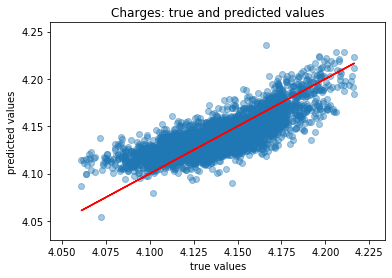

R-squared of the training set: 0.6159607095406607
-----Test set statistics-----
R-squared of the test set: 0.6135861729156795
Mean absolute error of the prediction: 0.012715770236885766
Mean squared error of the prediction: 0.00025260295595545254
Root mean squared error of the prediction: 0.015893487847400033
Mean absolute percentage error of the prediction: 0.30740152247208896


In [63]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()
print("R-squared of the training set: {}".format(ridgeCVregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(ridgeCVregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The R-squared and MAPE are comparable to OLS and thus this model does not add any predictive power.

#### Lasso Regression (L1)

When applying Lasso regression, we must similarly specify a lambda value (alpha in python).  In this analysis, we will use LassoCV to identify the best value.

In [64]:
lassoCVregr = LassoCV()
lassoCVregr.fit(X_train, y_train)
y_preds_train = lassoCVregr.predict(X_train)
y_preds_test = lassoCVregr.predict(X_test)
lassoCVregr.alpha_

0.10134498889469759

The value of lambda is an order of magnitude smaller and thus L1 regression should yield different results than OLS.

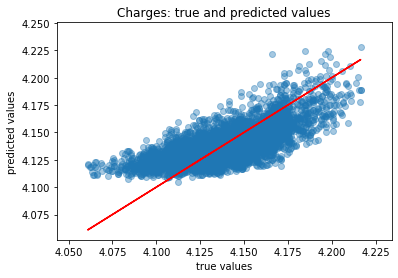

R-squared of the training set: 0.47790356420227736
-----Test set statistics-----
R-squared of the test set: 0.48383417715879107
Mean absolute error of the prediction: 0.01507035963755653
Mean squared error of the prediction: 0.00033742325836703593
Root mean squared error of the prediction: 0.01836908430943241
Mean absolute percentage error of the prediction: 0.36429871724065127


In [65]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(lassoCVregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(lassoCVregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Here, Lasso regression results in lower R-Squared and higher MAPE values, and thus is not as accurate at L2 or OLS regression.  In particular, it seems to overpredict low prices.

#### Elastinet Regression (L1 + L2)

ElasticNet combines the two previous regularization techniques.  For this analysis we will specify the L1 ratio to be 0.5.

In [66]:
elasticCVregr = ElasticNetCV(l1_ratio=0.5) 
elasticCVregr.fit(X_train, y_train)
y_preds_train = elasticCVregr.predict(X_train)
y_preds_test = elasticCVregr.predict(X_test)
elasticCVregr.alpha_

0.20268997778939518

The lambda value is about an order of magnitude off 1, and thus should result in a difference to OLS.

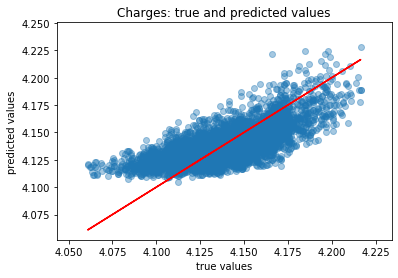

R-squared of the training set: 0.4779035626456215
-----Test set statistics-----
R-squared of the test set: 0.4838341755222204
Mean absolute error of the prediction: 0.015070359650620811
Mean squared error of the prediction: 0.0003374232594368801
Root mean squared error of the prediction: 0.01836908433855319
Mean absolute percentage error of the prediction: 0.3642987175665441


In [67]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the training set: {}".format(elasticCVregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(elasticCVregr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Again we encounter the tendency to overpredict low prices and thus a lrger error and lower R-Squared.  These two regularization techniques do not seem to be effective.  We should not expect them to because we do not have a large number of uncorrlated features that need to be minimized.  

#### Random Forest

For comparison to the regression techniques shown, I will implement a random forest model aswell.  I expect this model to perform well as it can exploit nuances in the data by making decision trees where the importance of one feature depends on the value of another.

In [68]:
Y = df['price_bxcx']
X = df[feat]

# Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)

# Adding constants to the feature train and test sets.
X_train_cons = sm.add_constant(X_train)

X_test_cons = sm.add_constant(X_test)

In [69]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, y_train)
y_preds_train = rfr.predict(X_train)
y_preds_test = rfr.predict(X_test)
cross_val_score(rfr, X_train, y_train, cv=5)

array([0.68067563, 0.68529014, 0.67510516, 0.6974015 , 0.68794253])

The model does not appear to overfit on any fold of the training set.

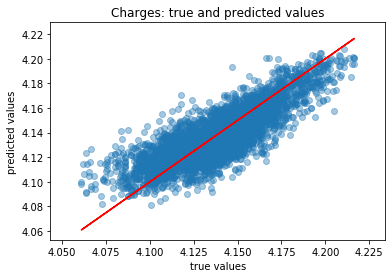

R-squared of the training set: 0.9543716241608112
-----Test set statistics-----
R-squared of the test set: 0.6976089422652314
Mean absolute error of the prediction: 0.010803634138294521
Mean squared error of the prediction: 0.000197676350286581
Root mean squared error of the prediction: 0.01405974218421451
Mean absolute percentage error of the prediction: 0.26121724579475597


In [70]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()
print("R-squared of the training set: {}".format(rfr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(rfr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The R-Squared value is higher than the 0.615 that we got for OLS and the MAPE is lower than the 30% for OLS. 

However, the training set R-Sqaured is significantly different than the test set's.  This is concerning, because it implies the Random Forest model that we implemented became overfit to the training data.  This model may not be resilient to novel data and thus its predictions cannot be fully trusted on new records.  

If we limit the depth of trees and number of estimators, can we avoid the overfit random forest model? 

In [71]:
rfr = ensemble.RandomForestRegressor(n_estimators = 10, max_depth = 5)
rfr.fit(X_train, y_train)
y_preds_train = rfr.predict(X_train)
y_preds_test = rfr.predict(X_test)
cross_val_score(rfr, X_train, y_train, cv=5)

array([0.61304656, 0.63439426, 0.62434046, 0.62125664, 0.63117651])

The R-Squared values are lower now that we have limited the random forest model.  It does not appear to overfit on the training data because the values are close across all 5 folds, lets see how it performs on the test data.

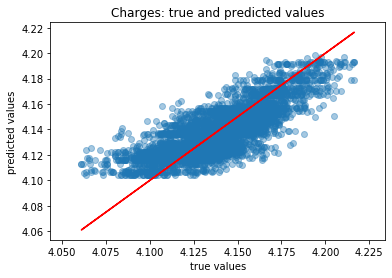

R-squared of the training set: 0.6358557777605629
-----Test set statistics-----
R-squared of the test set: 0.6272312219425942
Mean absolute error of the prediction: 0.012435970287056784
Mean squared error of the prediction: 0.00024368303778284642
Root mean squared error of the prediction: 0.015610350341451227
Mean absolute percentage error of the prediction: 0.3006653971691932


In [72]:
plt.scatter(y_test, y_preds_test, alpha = 0.4)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()
print("R-squared of the training set: {}".format(rfr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the test set: {}".format(rfr.score(X_test, y_test)))
print("Mean absolute error of the prediction: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Now the test and training data have comparable R-Squared values, so the model is no longer overfit.  Much like the linear regression models with L1 regularization, this model overpredicts many of the low values for houseprice.  Otherwise though, its R-Squared value of around 0.63 is slightly higher than the best performing linear regression model above, whiles the MAPE is the same at 30%. 

Now we can examine which feature the random forest model selects as most influential.

In [73]:
coefficients = list(zip(feat, rfr.feature_importances_))
RFR_coef = pd.DataFrame(data = coefficients, columns = ['feature', 'coefficient'])
RFR_coef['coef_by_range'] = range(0, RFR_coef.shape[0])

<BarContainer object of 15 artists>

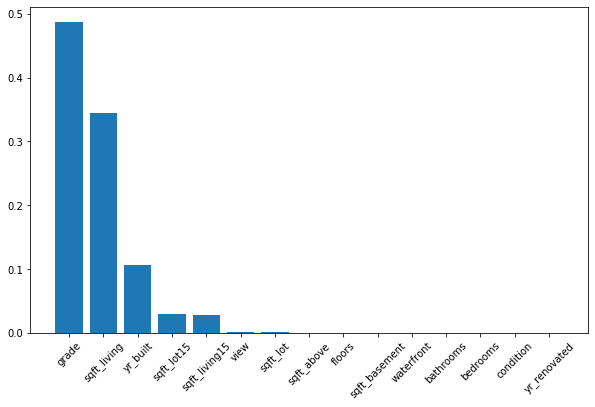

In [74]:
plt.figure(figsize = (10, 6))
plt.tick_params(axis = 'x', rotation = 45)
plt.bar(RFR_coef.sort_values(by = 'coefficient', ascending = False)['feature'], RFR_coef.sort_values(by = 'coefficient', ascending = False)['coefficient'])

We will quickly compare this to the OLS coefficients to see the difference each model picks out.

In [75]:
coeffient_comparison = pd.DataFrame()
coeffient_comparison['feature'] = feat
coeffient_comparison['OLS_coef'] = OLS_coef['coefficient'].copy()
coeffient_comparison['RFR_coef'] = RFR_coef['coefficient'].copy()
coeffient_comparison['OLS_coef_by_range'] = OLS_coef['coef_by_range'].copy()
coeffient_comparison

,feature,OLS_coef,RFR_coef,OLS_coef_by_range
0,bedrooms,0.000000e+00,0.000000,0.000000e+00
1,bathrooms,-1.236708e-03,0.000181,-9.275312e-03
2,sqft_living,4.249092e-03,0.344006,5.630047e+01
3,sqft_lot,4.404734e-06,0.001588,7.271507e+00
4,floors,1.319020e-08,0.000422,3.297549e-08
5,waterfront,6.207788e-03,0.000351,6.207788e-03
6,view,1.532456e-02,0.001945,6.129825e-02
7,condition,1.488330e-03,0.000000,1.488330e-03
8,grade,8.934374e-03,0.486936,1.072125e-01
9,sqft_above,9.885590e-03,0.000491,9.015658e+01


The scales are difficult to compare, but it is clear that the random forest model prioritized grade while OLS prioritized yr_built. 

Both model priotize sqft_living, so that seems to be the strongest predictor overall.

#### Support Vector Machine

Lastly I will implement a support vecotr regressor.  I do not expect this model to perform well since not all features scale linearly with the target and thus constructing a hyperplane will not be effective.

In [76]:
svr = SVR()
svr.fit(X, Y)
svr.score(X, Y)

-9.265966591631702e-05

A negative R-Squared implies this model has no predictive power.

In [77]:
cross_val_score(svr, X, Y, cv=5)

array([-3.11741582e-04, -7.29782513e-04, -7.58430659e-04, -3.54435207e-06,
       -1.58145976e-02])

Applying cross valuidation shows that the independent sets do not perform similarly and thus this model is no better than random noise.

### Conclusion

In this analysis, we determined that the Random Forest and Ordinary Least Squares mdodels are the most effective for predicting houseprices.  

The optimal Ridge Regression model has a lambda value so close to 1 that is is not better or worse than OLS.  Lasso and ElesticNet regression do not perform as well for predicting prices.  OLS does not overfit to the training set and has only 30% Mean Absolute Percentage Error.

The Random Forest model identifies grade as the most importand feature, but still ranks sqft_living highly, while the OLS model favors sqft_above and sqft_living and does not prioritize grade.  

The support vector regressor implementation does not have any predictive power and should not be considered.  

To further refine these modess, I would certainly focus on incorporating location.  Some combination of latitude, longitude, and zipcode could certainly improve the prodictive power of these models.  It would be useful to do more feature engineering such as subtracting sqft_above from sqft_lot to find yard size.  I would also like to use a grid search or similar technique to better tune the Random Forest model to both avoid overfitting while still maximizing R-Squared.